UFRN/PPGNeuro <br>
Rodrigo Santiago <br>
Natal, 2018/07


### Analysis of the boundary condition described by Radiske et al. (2017) using the Mismatch-Based Attractor Network developed by Osan, Tort and Amaral (2011)

[Osan, Remus, Adriano BL Tort, and Olavo B. Amaral. "A mismatch-based model for memory reconsolidation and extinction in attractor networks." PLoS One 6.8 (2011): e23113.](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0023113)

[Radiske, Andressa, et al. "Prior Learning of Relevant Nonaversive Information Is a Boundary Condition for Avoidance Memory Reconsolidation in the Rat Hippocampus." Journal of Neuroscience 37.40 (2017): 9675-9685.](http://www.jneurosci.org/content/37/40/9675)

---
** Some preliminary modules **

In [1]:
# General numerical module
import numpy as np

# Graphical module
from matplotlib import gridspec
import matplotlib.pyplot as plt
%matplotlib inline

# Statistical data visualization module
import seaborn as sns

# Probability Density Functions (PDFs)
from scipy.stats import gaussian_kde

#### Memory patterns

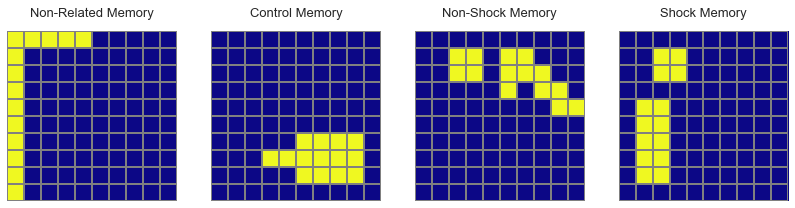

In [2]:
nNeurons      = 100 # amount of neurons in the network
nPatterns     = 4   # amount of memory patterns
patternWidth  = 10  # amount of matrix lines (width)
patternHeight = 10  # amount of matrix colummns (width)

# context engram
context = np.zeros(nNeurons)    # null array
indC    = [21,22,31,32]         # active neurons' indices
context[indC] = 1.              # sets engram to 1
context = context.reshape((patternHeight, patternWidth)) # matrix format

# arrays with -1 values
memNR   = np.ones(nNeurons)*-1. # non-related
memCtrl = np.ones(nNeurons)*-1. # control
memNS   = np.ones(nNeurons)*-1. # non-shock
memSh   = np.ones(nNeurons)*-1. # shock

# indices of the active neurons of each engram 
indNR   = [0,1,2,3,4,5,6,7,8,9,10,20,30,40]
indCtrl = [37,47,56,57,58,66,67,68,76,77,78,86,87,88]
indNS   = [21,22,31,32,51,52,53,61,62,72,73,83,84,94]
indSh   = [14,15,16,17,18,21,22,24,25,26,27,28,31,32]

# sets engram units to 1
memNR[indNR]     = 1.
memCtrl[indCtrl] = 1.
memNS[indNS]     = 1.
memSh[indSh]     = 1.

# memory patterns
X = np.zeros((nPatterns,nNeurons)) # array that stores the memory patterns
X[0] = memNR   # non-related memory pattern
X[1] = memCtrl # control
X[2] = memNS   # non-shock
X[3] = memSh   # shock

# plots
fig, ax = plt.subplots(1, nPatterns, figsize=(14,6))
titles = ['Non-Related Memory','Control Memory','Non-Shock Memory','Shock Memory']
for i in range(nPatterns):
    ax[i].matshow(X[i].reshape((patternHeight, patternWidth)).T, cmap='plasma')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_title(titles[i],size=13)
    # gridlines based on minor ticks
    ax[i].set_xticks(np.arange(-.5, 10, 1), minor=True)
    ax[i].set_yticks(np.arange(-.5, 10, 1), minor=True)
    ax[i].grid(which='minor', color='grey', linestyle='-', linewidth=2)

**Functions for storage, retrievals and plots:**

In [3]:
def trainNetwork(W0,u0,I,S,D):
    ''' Stores a pattern (trains the network) defined from a strong input and still returns the network
    steady-state. It can also be used for retrieving a pre-stored pattern, specially from a weak input.
    
    Parameters:
                W0: square matrix
                    Synaptic weights matrix that will be used for pattern retrieval and updated
                    from the input.
                u0: array-like
                    Initial neuronal states.
                I:  array-like
                    Network input.
                S:  float
                    Protein synthesis factor for the Hebbian learning.
                D:  float
                    Synpatic degradation factor.
    Returns:
                W:   square matrix
                     Updated matrix of synaptic weights.
                u:   array-like
                     Neuronal steady-state activity.
                t:   array-like
                     Time integration vector (in seconds).
                sol: array-like
                     Dynamics of neuronal activity.
    '''
    import numpy as np # general numerical module

    nNeurons = len(I) # amount of neurons
    tau = 1.          # neural time constant
    
    n = 100                    # number of integration points over time
    t0 = 0.                    # start time (in seconds)
    tf = 10.                   # end time (in seconds)
    t = np.linspace(t0,tf,n+1) # time vector (in seconds)
    dt = (tf-t0)/(n-1)         # integration time interval (in seconds)
    
    sol = [u0]                 # initial network state
    
    # Ordinary Differential Equation solver (via Euler's method)
    for i in range(1,n+1):
        # solutions for each time point
        sol.append(np.concatenate(dt*(-sol[i-1].reshape(-1,1)+0.5*\
                                      (1+np.tanh(np.dot(W0,sol[i-1].reshape(-1,1))+\
                                                 I.reshape(-1,1))))/tau + sol[i-1].reshape(-1,1)))
    u = sol[-1] # network steady-state
    
    # Prediction Error calculation
    if np.max(I) != 0:
        Inorm = (I/np.max(I)+1)/2 # normalized cue vector with values in [0,1]
    else: Inorm = I
    m = Inorm-u # mismatch vector

    # Update of the synaptic weights matrix
    HLP = S*np.outer(u,u)-S*(np.outer((1-u),u)) # hebbian-learning plasticity term
    MID = D*np.outer(m,u)                       # mismatch-induced degradation term
    W = W0 + HLP + MID                          # update
    W[W<-1] = -1.                               # very low values truncated at -1
    W[W>1]  = 1.                                # very high values truncated at +1
    
    return W,u,t,sol

In [4]:
def retrieval(nNeurons,W1,Ic,S,D,X,n):
    ''' Retrieves a pre-stored pattern and returns the step-down latecy (in seconds).
    
    Parameters:
                nNeurons: integer
                          Number of neurons in the network.
                W1:       square matrix
                          Matrix of synaptic weights used for retrieval.
                Ic:       array-like
                          Context/cue input pattern.
                S:        float
                          Protein synthesis factor (just to call the trainNetwork function)
                D:        float
                          Synpatic degradation factor (just to call the trainNetwork function).
                X:        matrix or array-like
                          Memory patterns (active neurons = 1; inactive ones = -1).
                n:        integer
                          Number of iterations/retrievals.
    Returns:
                SDL:      list
                          List with step-down latencies.
    '''
    import numpy as np # general numerical module
    np.random.seed()   # chooses a seed from the current time
    
    SDL = [] # list with step-down latencies
    for _ in range(n):
        u0 = np.random.rand(nNeurons)*0.1 # initial network state
        W,u,t,uDynamics = trainNetwork(W1,u0,Ic,S,D) # retrieval
        
        # Verifies which engram the retrieved pattern matches up
        # and chooses a SDL from the respective probability density function
        if np.dot(2*u-1.,X[3].T) > 95.: # if the shock pattern is retrieved
            latency = np.random.beta(3.52,1.5)*750
            if latency > 500.: latency = 500.
            SDL.append(latency)
        elif np.dot(2*u-1.,X[2].T) > 95.: # if the non-shock pattern is retrieved
            latency = np.random.beta(1.1,600)*15000
            if latency > 500.: latency = 500.
            SDL.append(latency)
        else: # if other retrieved memory pattern
            latency = np.random.beta(1.1,480)*35000
            if latency > 500.: latency = 500.
            SDL.append(latency)
    
    return SDL

In [5]:
def plotStorage(u0,I,u,t,uDynamics,W0,W):
    ''' Plots the initial network state, the network input, the neuronal steady-state,
    the neuronal dynamics, the initial synaptic matrix and the final one.
    
    Parameters:
                u0:        array-like
                           Initial network state.
                I:         array-like
                           Input (context/cue)
                u:         array-like
                           Neuronal steady-state.
                uDynamics: array-like
                           Network dynamics.
                W0:        square matrix
                           Matrix of synaptic weights before storage.
                W:         square matrix
                           Updated matrix of synaptic weights.
    '''
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib import gridspec
    import seaborn as sns
    
    sns.set(style="ticks")            # seaborn ticks-style
    fig = plt.figure(figsize=(18,10)) # figure size
    gs  = gridspec.GridSpec(2,3)      # grid for subplots
    
    # Plots the neuronal activity dynamics
    ax3 = plt.subplot(gs[1,0])
    ax3.plot(t,uDynamics,'k',linewidth=.5,alpha=0.3)
    ax3.set_xlabel('Time (t)',size=13)
    ax3.set_ylabel('Neuron activity (u)',size=13)
    ax3.set_title('Neuron activity dynamics',size=14)
    ax3.set_aspect(4.5,anchor='E')
    ax3.set_xlim([0,t[-50]])
    ax3.set_ylim([0,1])
    sns.despine()
    
    # Plots the initial neural activity
    ax0 = plt.subplot(gs[0,0])
    im0 = ax0.matshow(u0.reshape(10,10).T,cmap='plasma',vmin=0, vmax=1)
    ax0.set_title('Initial-state activity (u[t=0])',size=14,verticalalignment='bottom')
    ax0.set_xticks([0,9])
    ax0.set_yticks([0,9])
    fig.colorbar(im0,ax=ax0,fraction=0.0458,pad=0.04)

    # Plots the cortical input
    ax1 = plt.subplot(gs[0,1])
    im1 = ax1.matshow(I.reshape(10,10).T,cmap='plasma')
    ax1.set_title('Cortical input (I)',size=14,verticalalignment='bottom')
    ax1.set_xticks([0,9])
    ax1.set_yticks([0,9])
    ax1.set_aspect(1,anchor='W')
    fig.colorbar(im1,ax=ax1,fraction=0.0458,pad=0.04)
    
    # Plots the neural steady-state activity
    ax2 = plt.subplot(gs[0,2])
    im2 = ax2.matshow(u.reshape(10,10).T,cmap='plasma',vmin=0., vmax=1.)
    ax2.set_title('Steady-state activity (u[t=10])',size=14,verticalalignment='bottom')
    ax2.set_xticks([0,9])
    ax2.set_yticks([0,9])
    fig.colorbar(im2,ax=ax2,fraction=0.0458,pad=0.04)
    
    # Plots the matrix of synaptic weights before the storage.
    ax4 = plt.subplot(gs[1,1])
    im4 = ax4.matshow(W0,cmap='viridis',vmin=-1.,vmax=1.)
    ax4.set_title('Pre-storage synaptic weights',size=14,verticalalignment='bottom')
    ax4.set_xticks([0,99])
    ax4.set_yticks([0,99])
    fig.colorbar(im4,ax=ax4,fraction=0.0458,pad=0.04)
    
    # Plots the updated matrix of synaptic weights after the storage.
    ax5 = plt.subplot(gs[1,2])
    im5 = ax5.matshow(W,cmap='viridis',vmin=-1.,vmax=1.)
    ax5.set_title('Post-storage synaptic weights',size=14,verticalalignment='bottom')
    ax5.set_xticks([0,99])
    ax5.set_yticks([0,99])
    fig.colorbar(im5,ax=ax5,fraction=0.0458,pad=0.04);

In [6]:
def plotRetrieval(u0,I,u,t,uDynamics):
    ''' Plots the initial network state, the network input, the network dynamics and the
    steady-state retrieved.
    
    Parameters:
                u0:        array-like
                           Initial network state.
                I:         array-like
                           Input (context/cue)
                u:         array-like
                           Neuronal steady-state (retrieved pattern).
                uDynamics: array-like
                           Network dynamics.
    '''
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib import gridspec
    import seaborn as sns
    
    sns.set(style="ticks")            # seaborn ticks-style
    fig = plt.figure(figsize=(11,10)) # figure size
    gs  = gridspec.GridSpec(2,2)      # grid for subplots
    
    # Plots the neural activity dynamics
    ax3 = plt.subplot(gs[1,0])
    ax3.plot(t,uDynamics,'k',linewidth=.5,alpha=0.3)
    ax3.set_xlabel('Time (t)',size=13)
    ax3.set_ylabel('Neuron activity (u)',size=13)
    ax3.set_title('Neuron activity dynamics',size=14)
    ax3.set_aspect(4.5,anchor='E')
    ax3.set_xlim([0,t[-50]])
    ax3.set_ylim([0,1])
    sns.despine()
    
    # Plots the initial neural activity
    ax0 = plt.subplot(gs[0,0])
    im0 = ax0.matshow(u0.reshape(10,10).T,cmap='plasma',vmin=0, vmax=1)
    ax0.set_title('Initial-state activity (u[t=0])',size=14,verticalalignment='bottom')
    ax0.set_xticks([0,9])
    ax0.set_yticks([0,9])
    fig.colorbar(im0,ax=ax0,fraction=0.0458,pad=0.04)

    # Plots the cortical input
    ax1 = plt.subplot(gs[0,1])
    im1 = ax1.matshow(I.reshape(10,10).T,cmap='plasma',vmin=0, vmax=1)
    ax1.set_title('Cortical input (I)',size=14,verticalalignment='bottom')
    ax1.set_xticks([0,9])
    ax1.set_yticks([0,9])
    ax1.set_aspect(1,anchor='W')
    fig.colorbar(im1,ax=ax1,fraction=0.0458,pad=0.04)
    
    # Plots the neuronal steady-state activity (retrieved pattern)
    ax2 = plt.subplot(gs[1,1])
    im2 = ax2.matshow(u.reshape(10,10).T,cmap='plasma',vmin=0., vmax=1.)
    ax2.set_title('Steady-state activity (u[t=10])',size=14,verticalalignment='bottom')
    ax2.set_xticks([0,9])
    ax2.set_yticks([0,9])
    fig.colorbar(im2,ax=ax2,fraction=0.0458,pad=0.04)

In [7]:
def SDL_Protocol1(nNeurons,Inr,Iha,Ins,Ic,Ish,T,n,gamma,gammaRA,gammaSh,habitS,amnesicS,aversiveS,reactS,D,X):
    ''' Computes the step-down latencies post-reexposure (following the experimental protocol)
    for Vehicle and Aniso groups.
    
    Parameters:
                nNeurons:  integer
                           Number of neurons in the network.
                Inr:       array-like
                           Non-related input pattern.
                Iha:       array-like
                           Habituation input pattern.
                Ins:       array-like
                           Non-shock input pattern.
                Ic:        array-like
                           Context/cue input pattern.
                Ish:       array-like
                           Shock input pattern.
                T:         float
                           Indicates the reexposition input pattern.
                n:         integer
                           Number of retrievals.
                gamma:     float
                           Time-dependent synaptic decay factor.
                gammaRA:   float
                           Time-dependent synaptic decay factor to be used after reexposition.
                gammaSh:   float
                           Time-dependent synaptic decay factor to be used after training.
                habitS:    float
                           Synthesis factor applied at habituation.
                amnesicS:  float
                           Synthesis factor applied at reexposure for Aniso group.
                aversiveS: float
                           Synthesis factor applied at training.
                reactS:    float
                           Synthesis factor applied at reexposure for Vehicle group.
                D:         float
                           Synpatic degradation factor.
                X:         matrix or array-like
                           Memory patterns (active neurons = 1; inactive ones = -1).
    Returns:
                SDL_Median:    list
                               Medians of the step-down latencies.
                SDL_75quartil: list
                               Upper interquartiles of the step-down latencies.
                SDL_25quartil: list
                               Lower interquartiles of the step-down latencies.
    '''
    import numpy as np # general numerical module
    np.random.seed()   # chooses a seed from the current time
    
    SDL_Median    = [] # list with the medians of the step-down latencies
    SDL_75quartil = [] # list with the 75-quartil of the step-down latencies
    SDL_25quartil = [] # list with the 25-quartil of the step-down latencies
    
    W0 = np.zeros((nNeurons,nNeurons)) # matrix of weights initialization
    
    # Non-related memory storage
    S = 0.8 # synthesis factor
    u0 = np.random.rand(nNeurons)*0.1 # initial network state
    Wnr,u,t,uDynamics = trainNetwork(W0,u0,Inr,S,D) # storage
    Wnr = (1.-gamma)*Wnr # time-dependent synaptic decay
    
    # Habituation
    S = habitS  # synthesis factor
    u0 = np.random.rand(nNeurons)*0.1 # initial network state
    Wha,u,t,uDynamics = trainNetwork(Wnr,u0,Iha,S,D) # storage
    Wha = (1.-gamma)*Wha # time-dependent synaptic decay

    # Shock memory storage (Training)
    S = aversiveS # systhesis factor for aversive memory
    u0 = np.random.rand(nNeurons)*0.1 # initial network state
    Wsh,u,t,uDynamics = trainNetwork(Wha,u0,Ish,S,D) # storage
    Wsh = (1.-gammaSh)*Wsh # time-dependent synaptic decay

    ### VEHICLE ###
    # SD-IA Reactivation
    S = reactS  # synthesis factor
    I = Ish+(Ins-Ish)/(1+np.exp(10./2.-T))
    u0 = np.random.rand(nNeurons)*0.1 # initial network state
    Wra,u,t,uDynamics = trainNetwork(Wsh,u0,I,S,D) # storage
    Wra = (1.-gammaRA)*Wra # time-dependent synaptic decay

    # Test day
    SDL = retrieval(nNeurons,Wra,Ic,S,D,X,n) # retrieval

    # SDL median and interquartile range
    SDL_Median.append(np.median(SDL))
    SDL_75quartil.append(np.percentile(SDL, 75))
    SDL_25quartil.append(np.percentile(SDL, 25))
    ###############

    ### ANISO ###
    # SD-IA Reactivation
    S = amnesicS # synthesis factor
    u0 = np.random.rand(nNeurons)*0.1 # initial network state
    Wra,u,t,uDynamics = trainNetwork(Wsh,u0,I,S,D) # storage
    Wra = (1.-gammaRA)*Wra # time-dependent synaptic decay

    # Test day
    SDL = retrieval(nNeurons,Wra,Ic,S,D,X,n) # retrieval

    # SDL median and interquartile range
    SDL_Median.append(np.median(SDL))
    SDL_75quartil.append(np.percentile(SDL, 75))
    SDL_25quartil.append(np.percentile(SDL, 25))
    ###############
    
    return SDL_Median,SDL_75quartil,SDL_25quartil

#### Setting some parameters and input patterns

In [8]:
D         = 1.25 # degradation factor
gamma     = 0.15 # time-dependent synaptic decay factor
mStrength = 5.   # memory strength
cStrength = 0.1  # cue/context strength

Ic  = cStrength*np.concatenate(context) # cue input (context)
Inr = mStrength*X[0].copy() # cortical input (non-related memory)
Ict = mStrength*X[1].copy() # cortical input (control memory)
Ins = mStrength*X[2].copy() # cortical input (non-shock memory)
Ish = mStrength*X[3].copy() # cortical input (shock memory)

W0 = np.zeros((nNeurons,nNeurons)) # matrix of weights initialization

#### Initial memory storage

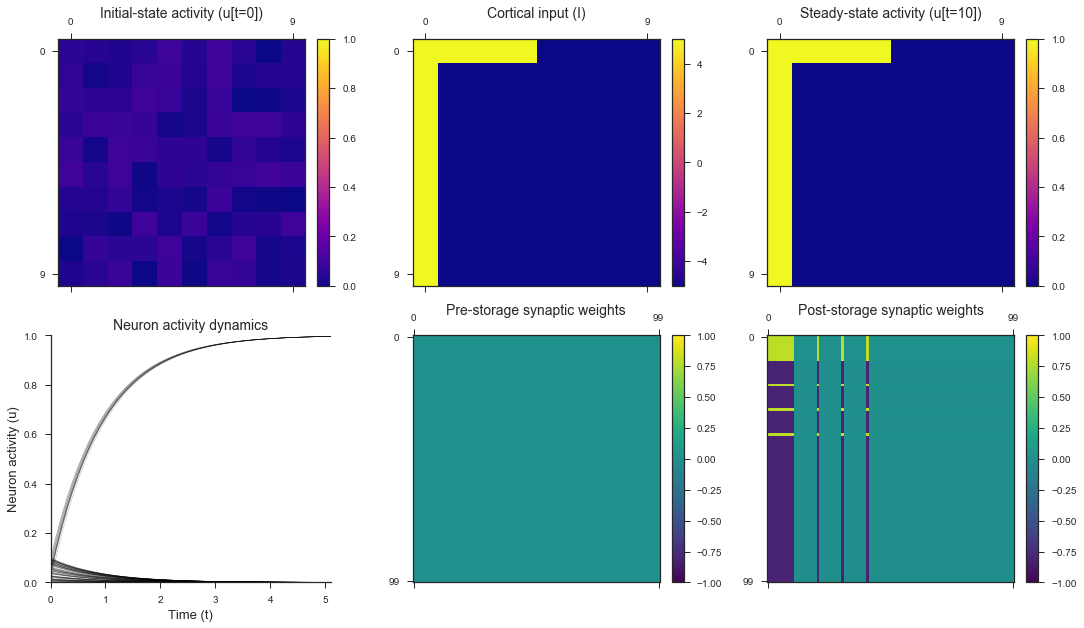

In [9]:
u0 = np.random.rand(nNeurons)*0.1 # initial network state

# Storage
S = 0.8  # synthesis factor
W,u,t,uDynamics = trainNetwork(W0,u0,Inr,S,D)

# Plots of the dynamics of neuronal activity and
# changes in the matrix of synaptic weights
plotStorage(u0,Inr,u,t,uDynamics,W0,W)

#### Habituation

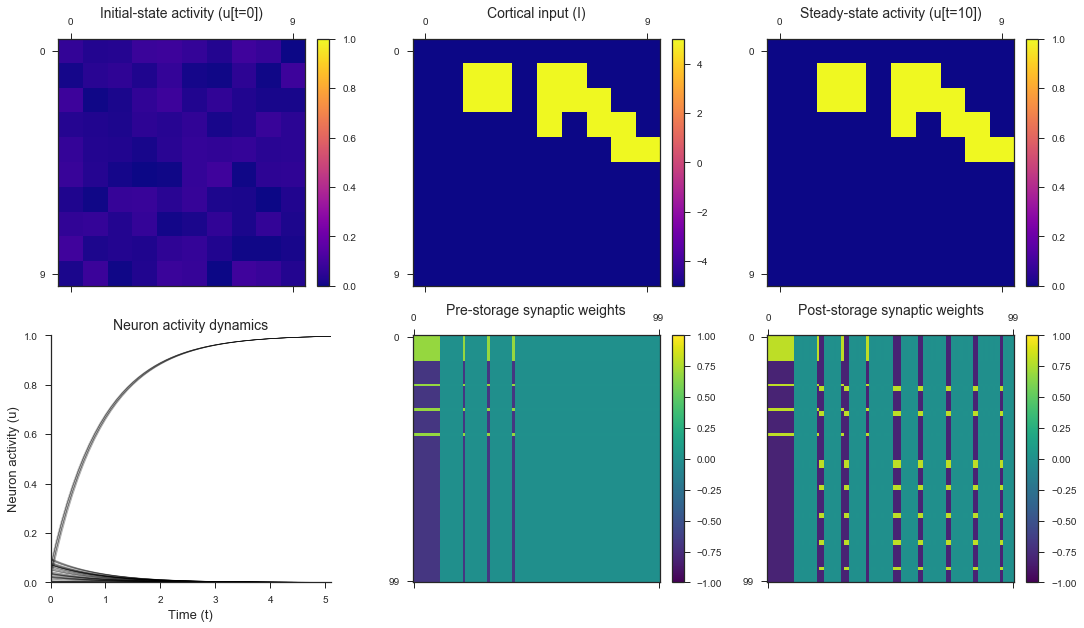

In [10]:
W0 = (1.-gamma)*W.copy()          # input weight matrix updating
u0 = np.random.rand(nNeurons)*0.1 # initial network state

# Storage
S = 0.8  # synthesis factor
# here use Ins for "non-shock pattern" or Ict for "control" one
W,u,t,uDynamics = trainNetwork(W,u0,Ins,S,D)

# Plots of the dynamics of neuronal activity and
# changes in the matrix of synaptic weights
plotStorage(u0,Ins,u,t,uDynamics,W0,W)

#### Training

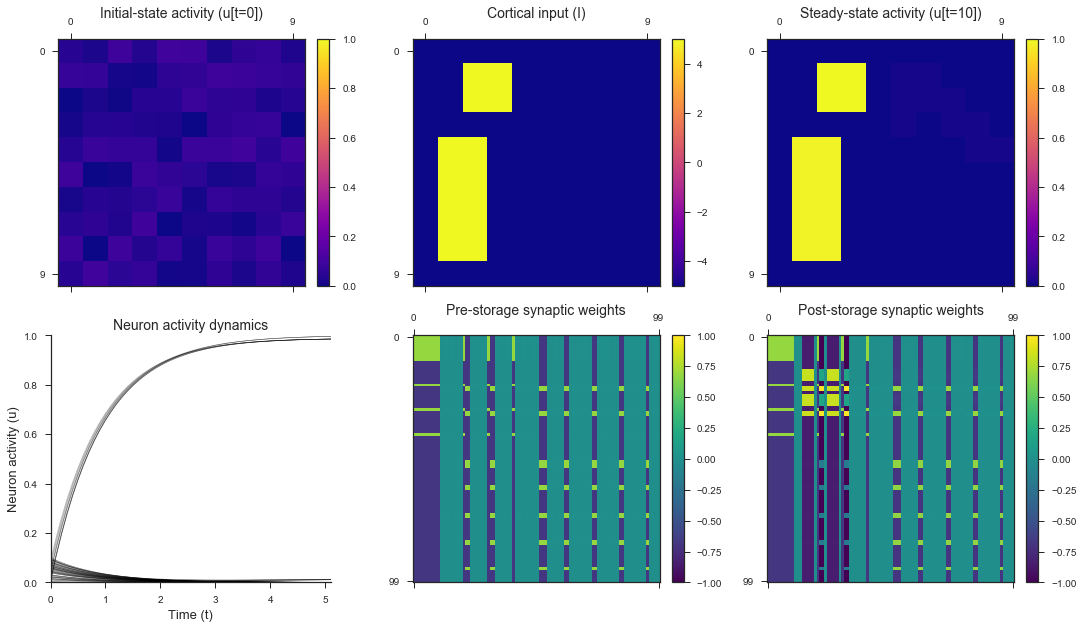

In [11]:
W0 = (1.-gamma)*W.copy()          # input weight matrix updating
u0 = np.random.rand(nNeurons)*0.1 # initial network state

# Storage
S = 0.85  # synthesis factor
W,u,t,uDynamics = trainNetwork(W0,u0,Ish,S,D)

# Plots of the dynamics of neuronal activity and
# changes in the matrix of synaptic weights
plotStorage(u0,Ish,u,t,uDynamics,W0,W)

#### Reexposition

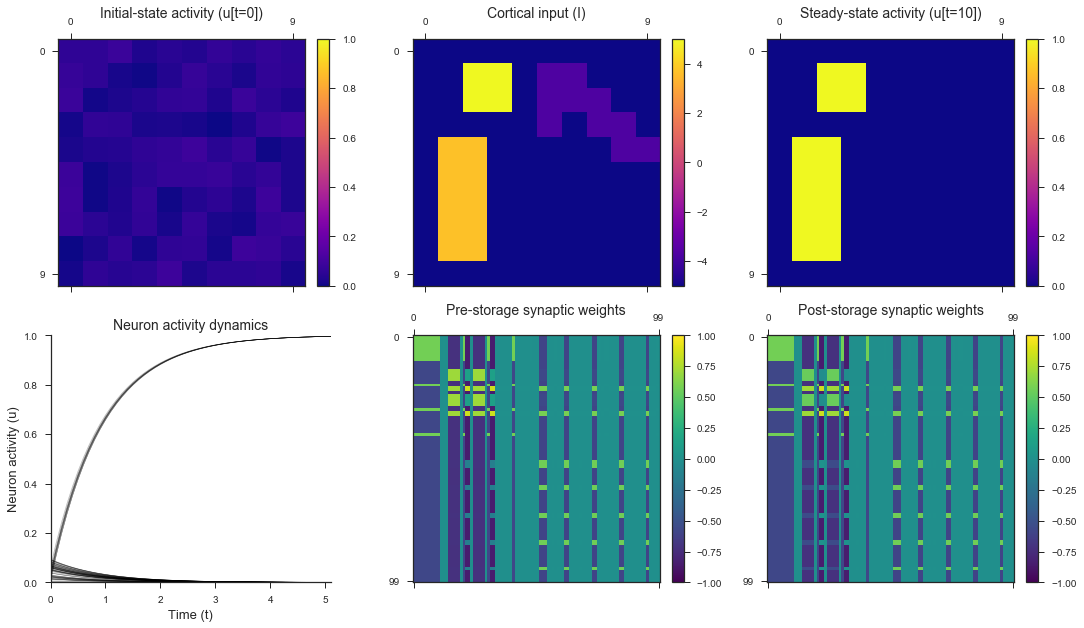

In [12]:
W0 = (1.-gamma)*W.copy()          # input weight matrix updating
u0 = np.random.rand(nNeurons)*0.1 # initial network state

T = 3.1  # defines the input pattern
I = Ish+(Ins-Ish)/(1+np.exp(10./2.-T))

# Storage
# S = 0.85 # VEHICLE synthesis factor
S = 0.   # ANISO synthesis factor
W,u,t,uDynamics = trainNetwork(W0,u0,I,S,D)

# Plots of the dynamics of neuronal activity and
# changes in the matrix of synaptic weights
plotStorage(u0,I,u,t,uDynamics,W0,W)

#### Retrieval from context

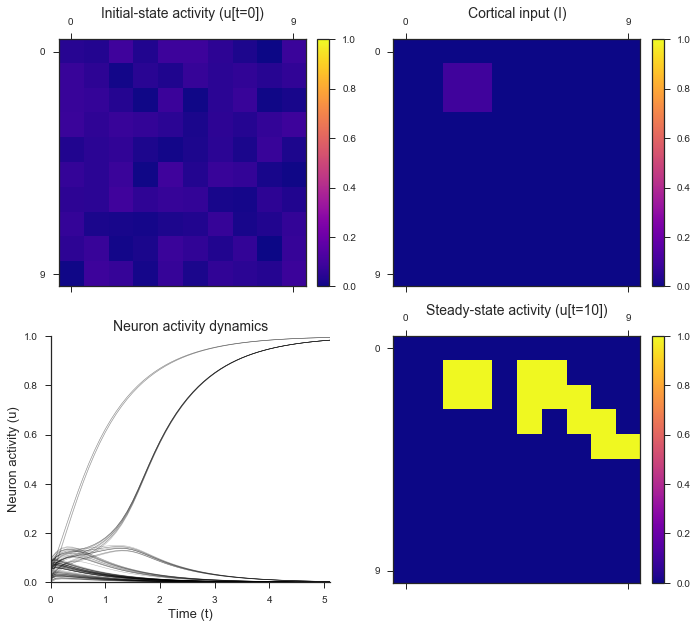

In [13]:
W0 = (1.-gamma)*W.copy()          # input weight matrix updating
u0 = np.random.rand(nNeurons)*0.1 # initial network state

W,u,t,uDynamics = trainNetwork(W0,u0,Ic,S,D) # retrieval

plotRetrieval(u0,Ic,u,t,uDynamics)

Retrieval dynamics when t = 0.0, 0.5, 1.0, 1.5 and 3.0 seconds:

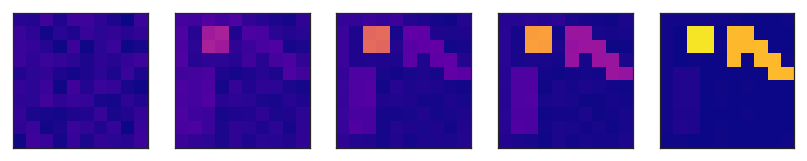

In [14]:
fig, ax = plt.subplots(1,5,figsize=(14,6))
count=0
for i in [0,5,10,15,30]:
    ax[count].matshow(uDynamics[i].reshape((10,10)).T, cmap='plasma',vmin=0, vmax=1)
    ax[count].set_xticks([])
    ax[count].set_yticks([])
    count+=1

#### Behavioral simulations

Step-down latency probability distributions for each retrieved memory pattern:
<br>
(The probability density functions defined here are incorporated in the "retrieval" function above.)

In [15]:
nsamples = 30000 # number of samples of each distribution

shockSDL    = np.random.beta(3.52,1.5,nsamples)*750  # shock
nonshockSDL = np.random.beta(1.1,600,nsamples)*15000 # non-shock
otherSDL    = np.random.beta(1.1,480,nsamples)*35000 # other

# Samples in ascending order
sortedshockSDL    = np.sort(shockSDL)
sortednonshockSDL = np.sort(nonshockSDL)
sortedotherSDL    = np.sort(otherSDL)

# Representation of kernel-density estimates via Gaussian kernels
kdeshock    = gaussian_kde(sortedshockSDL)
kdenonshock = gaussian_kde(sortednonshockSDL)
kdeother    = gaussian_kde(sortedotherSDL)

# Probability Density Functions
shockPDF    = kdeshock(sortedshockSDL)
nonshockPDF = kdenonshock(sortednonshockSDL)
otherPDF    = kdeother(sortedotherSDL)

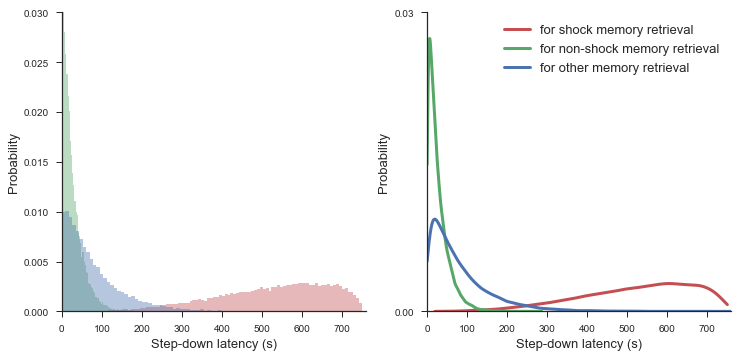

In [16]:
plt.figure(figsize=(12,5.5))

plt.subplot(121) # density histograms
plt.hist(shockSDL,100,normed=True,color='C2',alpha=0.4)
plt.hist(nonshockSDL,100,normed=True,color='C1',alpha=0.4)
plt.hist(otherSDL,100,normed=True,color='C0',alpha=0.4)
plt.xlim([0,760])
plt.ylim([0,0.03])
plt.xlabel('Step-down latency (s)',size=13)
plt.ylabel('Probability',size=13)
sns.despine()

plt.subplot(122) # PDFs
plt.plot(sortedshockSDL,shockPDF,'C2',label='for shock memory retrieval',linewidth=3)
plt.plot(sortednonshockSDL,nonshockPDF,'C1',label='for non-shock memory retrieval',linewidth=3)
plt.plot(sortedotherSDL,otherPDF,'C0',label='for other memory retrieval',linewidth=3)
plt.xlim([0,760])
plt.ylim([0,0.03])
plt.yticks([0,0.03])
plt.xlabel('Step-down latency (s)',size=13)
plt.ylabel('Probability',size=13)
plt.legend(fontsize=13)
sns.despine()

Schematic representation of the experimental protocol:

<img src="ExpProtocol.png", style="width: 360px;">

Cortical inputs:

In [17]:
mStrength = 5.  # memory strength
cStrength = 0.1 # cue/context strength

Ic  = cStrength*np.concatenate(context) # cue/context input (context)
Inr = mStrength*X[0].copy() # cortical input (non-related memory)
Ict = mStrength*X[1].copy() # cortical input (control memory)
Ins = mStrength*X[2].copy() # cortical input (non-shock memory)
Ish = mStrength*X[3].copy() # cortical input (shock memory)

Retention tests after each stage:<br>

In [18]:
n = 1000       # amount of retrievals
T = 3.1        # input pattern at reexposure
gamma = 0.15   # time-dependent synaptic decay factor
gammaRA = 0.15 # gamma after reexposure
D = 1.25       # synaptic degradation factor

np.random.seed()

SDL_Median    = [] # list with the medians of the step-down latencies
SDL_75quartil = [] # list with the 75-quartil of the step-down latencies
SDL_25quartil = [] # list with the 25-quartil of the step-down latencies

# Matrix of weights initialization
W0 = np.zeros((nNeurons,nNeurons))

# Non-related memory storage
S = 0.8 # synthesis factor
u0 = np.random.rand(nNeurons)*0.1 # initial network state
Wnr,u,t,uDynamics = trainNetwork(W0,u0,Inr,S,D) # storage
Wnr = (1.-gamma)*Wnr # time-dependent synaptic decay

# Habituation (CONTROL)
S = 0.8
u0 = np.random.rand(nNeurons)*0.1
Wha,u,t,uDynamics = trainNetwork(Wnr,u0,Ict,S,D)
Wha = (1.-gamma)*Wha

# Tests after habituation
SDL = retrieval(nNeurons,Wha,Ic,S,D,X,n) # retrieval tests
SDL_Median.append(np.median(SDL))            # median
SDL_75quartil.append(np.percentile(SDL, 75)) # upper interquartil
SDL_25quartil.append(np.percentile(SDL, 25)) # lower interquartil

# Training (shock)
S = 0.85
u0 = np.random.rand(nNeurons)*0.1
Wsh,u,t,uDynamics = trainNetwork(Wha,u0,Ish,S,D)
Wsh = (1.-gamma)*Wsh

# Tests after training
SDL = retrieval(nNeurons,Wsh,Ic,S,D,X,n)
SDL_Median.append(np.median(SDL))
SDL_75quartil.append(np.percentile(SDL, 75))
SDL_25quartil.append(np.percentile(SDL, 25))

# Reexposure (vehicle)
S = 0.85
I = Ish+(Ins-Ish)/(1+np.exp(10./2.-T))
u0 = np.random.rand(nNeurons)*0.1
Wra,u,t,uDynamics = trainNetwork(Wsh,u0,I,S,D)
Wra = (1.-gammaRA)*Wra

# Tests after reexposure (vehicle)
SDL = retrieval(nNeurons,Wra,Ic,S,D,X,n)
SDL_Median.append(np.median(SDL))
SDL_75quartil.append(np.percentile(SDL, 75))
SDL_25quartil.append(np.percentile(SDL, 25))

# Reexposure (aniso)
S = 0.
I = Ish+(Ins-Ish)/(1+np.exp(10./2.-T))
u0 = np.random.rand(nNeurons)*0.1
Wra,u,t,uDynamics = trainNetwork(Wsh,u0,I,S,D)
Wra = (1.-gammaRA)*Wra

# Tests after reexposure (aniso)
SDL = retrieval(nNeurons,Wra,Ic,S,D,X,n)
SDL_Median.append(np.median(SDL))
SDL_75quartil.append(np.percentile(SDL, 75))
SDL_25quartil.append(np.percentile(SDL, 25))

# Habituation (NON-SHOCK)
S = 0.8
u0 = np.random.rand(nNeurons)*0.1
Wha,u,t,uDynamics = trainNetwork(Wnr,u0,Ins,S,D)
Wha = (1.-gamma)*Wha

# Tests after habituation
SDL = retrieval(nNeurons,Wha,Ic,S,D,X,n)
SDL_Median.append(np.median(SDL))
SDL_75quartil.append(np.percentile(SDL, 75))
SDL_25quartil.append(np.percentile(SDL, 25))

# Training (shock)
S = 0.85
u0 = np.random.rand(nNeurons)*0.1
Wsh,u,t,uDynamics = trainNetwork(Wha,u0,Ish,S,D)
Wsh = (1.-gamma)*Wsh

# Tests after training
SDL = retrieval(nNeurons,Wsh,Ic,S,D,X,n)
SDL_Median.append(np.median(SDL))
SDL_75quartil.append(np.percentile(SDL, 75))
SDL_25quartil.append(np.percentile(SDL, 25))

# Reexposure (vehicle)
S = 0.85
I = Ish+(Ins-Ish)/(1+np.exp(10./2.-T))
u0 = np.random.rand(nNeurons)*0.1
Wra,u,t,uDynamics = trainNetwork(Wsh,u0,I,S,D)
Wra = (1.-gammaRA)*Wra

# Tests after reexposure (vehicle)
SDL = retrieval(nNeurons,Wra,Ic,S,D,X,n)
SDL_Median.append(np.median(SDL))
SDL_75quartil.append(np.percentile(SDL, 75))
SDL_25quartil.append(np.percentile(SDL, 25))

# Reexposure (aniso)
S = 0.
I = Ish+(Ins-Ish)/(1+np.exp(10./2.-T))
u0 = np.random.rand(nNeurons)*0.1
Wra,u,t,uDynamics = trainNetwork(Wsh,u0,I,S,D)
Wra = (1.-gammaRA)*Wra

# Tests after reexposure (aniso)
SDL = retrieval(nNeurons,Wra,Ic,S,D,X,n)
SDL_Median.append(np.median(SDL))
SDL_75quartil.append(np.percentile(SDL, 75))
SDL_25quartil.append(np.percentile(SDL, 25))

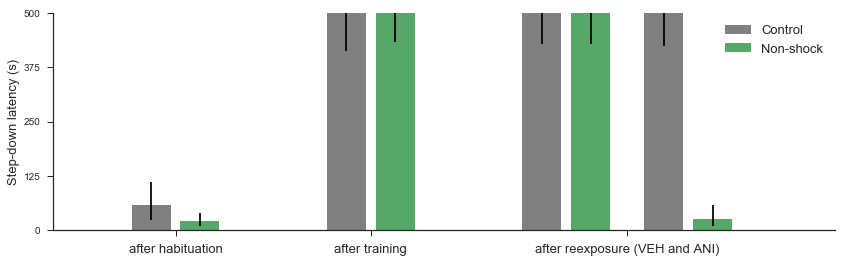

In [19]:
plt.figure(figsize=(14,4))
plt.bar(2,SDL_Median[0],yerr=[[SDL_Median[0]-SDL_25quartil[0]],[SDL_75quartil[0]-SDL_Median[0]]],\
        label='Control',color='grey')
plt.bar(3,SDL_Median[4],yerr=[[SDL_Median[4]-SDL_25quartil[4]],[SDL_75quartil[4]-SDL_Median[4]]],\
        label='Non-shock',color='C1')
plt.bar(6,SDL_Median[1],yerr=[[SDL_Median[1]-SDL_25quartil[1]],[SDL_75quartil[1]-SDL_Median[1]]],\
        color='grey')
plt.bar(7,SDL_Median[5],yerr=[[SDL_Median[5]-SDL_25quartil[5]],[SDL_75quartil[5]-SDL_Median[5]]],\
        color='C1')
plt.bar(10,SDL_Median[2],yerr=[[SDL_Median[2]-SDL_25quartil[2]],[SDL_75quartil[2]-SDL_Median[2]]],\
        color='grey')
plt.bar(11,SDL_Median[6],yerr=[[SDL_Median[6]-SDL_25quartil[6]],[SDL_75quartil[6]-SDL_Median[6]]],\
        color='C1')
plt.bar(12.5,SDL_Median[3],yerr=[[SDL_Median[3]-SDL_25quartil[3]],[SDL_75quartil[3]-SDL_Median[3]]],\
        color='grey')
plt.bar(13.5,SDL_Median[7],yerr=[[SDL_Median[7]-SDL_25quartil[7]],[SDL_75quartil[7]-SDL_Median[7]]],\
        color='C1')
plt.xlim([0,16])
plt.ylim([0,500])
plt.ylabel('Step-down latency (s)',size=13)
plt.xticks([2.5,6.5,11.75],['after habituation','after training','after reexposure (VEH and ANI)'],size=13)
plt.yticks([0,125,250,375,500])
plt.legend(fontsize=13)
sns.despine();

Percentuals of retrievals from the "non-shock" habituation group after reexposition with "aniso" (last group from the simulation above):

In [20]:
# Number of retrieval percentuals of each pattern (shock, non-shock and others)
nPercentuals = np.zeros((10,3))

# Here we calculate the percentual of 100 retrievals for 10 times.
for i in range(10):
    np.random.seed()
    nRetrievals = np.zeros(3)
    for j in range(100):
        u0 = np.random.rand(nNeurons)*0.1 # initial network state
        W,u,t,uDynamics = trainNetwork(Wra,u0,Ic,S,D) # retrieval

        # Verifies with which memory pattern the retrieved network state matches up
        # (more than 95% of the units retrieved states should correlate with those of any pattern)
        if np.dot(2*u-1.,X[3].T) > 95.: # shock
            nRetrievals[0]+=1
        elif np.dot(2*u-1.,X[2].T) > 95.: # non-shock
            nRetrievals[1]+=1
        else: # for other memory pattern
            nRetrievals[2]+=1
    nPercentuals[i] = nRetrievals/np.sum(nRetrievals)  

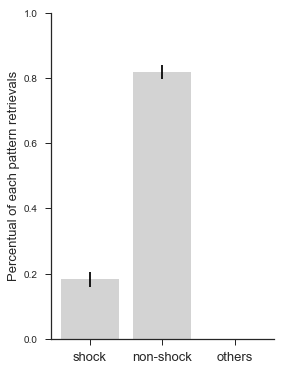

In [21]:
plt.figure(figsize=((4,6)))
plt.bar(1,np.mean(nPercentuals[:,0]),yerr=np.std(nPercentuals[:,0]),color='lightgrey',label='shock')
plt.bar(2,np.mean(nPercentuals[:,1]),yerr=np.std(nPercentuals[:,1]),color='lightgrey',label='non-shock')
plt.bar(3,np.mean(nPercentuals[:,2]),yerr=np.std(nPercentuals[:,2]),color='lightgrey',label='non-shock')
plt.xticks([1,2,3],['shock','non-shock','others'],size=13)
plt.ylabel('Percentual of each pattern retrievals',size=13)
plt.ylim([0,1])
sns.despine()
from pylab import savefig
savefig('percentRet.svg');

Considering both habituation groups, here we calculate the energies of the "shock" and "non-shock" attractors after reexposure with T = 3.1 (VEH and ANI):

In [22]:
gamma     = 0.15 # decay factor applied after habituation and training
habS      = 0.8  # synthesis factor at habituation stage
amnesicS  = 0.   # synthesis factor that simulates the amnesic drug
aversiveS = 0.85 # synthesis factor for aversive memory storage
D         = 1.25 # degradation factor
T         = 3.1  # reexposure pattern
nPoints   = 2    # number of points of each trace

E = np.zeros((8,nPoints))       # matrix with energy values
allPatterns = (X+1)/2           # all patterns (with states=[0,1])
# somePatterns = allPatterns[2:4] # shock and non-shock patterns
scenario = -1                   # indicates habituation scenario

for Ihab in [Ict,Ins]: # for each habituation input patern
    for pattern in range(4): # for each attractor
        
        scenario += 1 # indicates the habituation group (control/non-shock)
        count = 0 # indicates the reexposure group (vehicle/aniso)
        for reactS in [0.85,0.]: # synthesis factor at reexposure
            np.random.seed()
            
            # Matrix of weights initialization
            W0 = np.zeros((nNeurons,nNeurons))
            
            # Non-related memory storage
            u0 = np.random.rand(nNeurons)*0.1 # initial network state
            Wnr,u,t,uDynamics = trainNetwork(W0,u0,Inr,habS,D) #storage
            Wnr = (1.-gamma)*Wnr # time-dependent synptic decay

            # Habituation
            u0 = np.random.rand(nNeurons)*0.1 # initial network state
            Wha,u,t,uDynamics = trainNetwork(Wnr,u0,Ihab,habS,D) # storage
            Wha = (1.-gamma)*Wha # time-dependent synptic decay

            # Shock memory storage (Training)
            u0 = np.random.rand(nNeurons)*0.1 # initial network state
            Wsh,u,t,uDynamics = trainNetwork(Wha,u0,Ish,aversiveS,D) # storage
            Wsh = (1.-gamma)*Wsh # time-dependent synptic decay

            # SD-IA Reactivation
            I = Ish+(Ins-Ish)/(1+np.exp(10./2.-T))
            u0 = np.random.rand(nNeurons)*0.1 # initial network state
            Wra,u,t,uDynamics = trainNetwork(Wsh,u0,I,reactS,D) # storage
            Wra = (1.-gamma)*Wra # time-dependent synptic decay

            # Energy calculation
            Sum = 0 # sum from the energy equation
            for i in range(nNeurons):
                for j in range(nNeurons):
                    Sum += Wra[i,j]*allPatterns[pattern,j]*(2*allPatterns[pattern,i]-1.)
            E[scenario,count] += -Sum # energy values
            count+=1 # changes position of E to "1" for storing "aniso" group energy

E = (E - np.min(E))/(np.max(E)-np.min(E)) # normalization
print E

[[ 0.5087282   0.50872873]
 [ 0.42203571  0.42203609]
 [ 0.82855927  0.86684401]
 [ 0.          0.31007429]
 [ 0.50874277  0.50874297]
 [ 0.9999995   1.        ]
 [ 0.40210701  0.38782417]
 [ 0.00987321  0.32111315]]


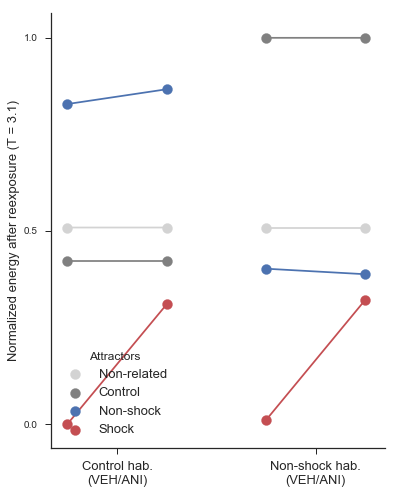

In [23]:
plt.figure(figsize=(6,8))

plt.plot([1,2],E[0],color='lightgrey')
plt.scatter([1,2],E[0],s=100,color='lightgrey')
plt.plot([1,2],E[1],color='grey')
plt.scatter([1,2],E[1],s=100,color='grey')
plt.plot([1,2],E[2],color='C0')
plt.scatter([1,2],E[2],s=100,color='C0')
plt.plot([1,2],E[3],color='C2')
plt.scatter([1,2],E[3],s=100,color='C2')

plt.plot([3,4],E[4],color='lightgrey')
plt.scatter([3,4],E[4],s=100,color='lightgrey',label='Non-related')
plt.plot([3,4],E[5],color='grey')
plt.scatter([3,4],E[5],s=100,color='grey',label='Control')
plt.plot([3,4],E[6],color='C0')
plt.scatter([3,4],E[6],s=100,color='C0',label='Non-shock')
plt.plot([3,4],E[7],color='C2')
plt.scatter([3,4],E[7],s=100,color='C2',label='Shock')

plt.xticks([1,2,3,4])
plt.yticks([0.,0.5,1.])
plt.legend(title='Attractors',fontsize=13)
plt.xticks([1.5,3.5],['Control hab.\n(VEH/ANI)','Non-shock hab.\n(VEH/ANI)'],size=13)
plt.ylabel('Normalized energy after reexposure (T = 3.1)',size=13)
sns.despine();

**Effect of S value at habituation in relation to the exposure period at reactivation:**

Control habituation.

In [24]:
SDL_MedianV = [] # list with the medians of the step-down latencies (vehicle)
SDL_MedianA = [] # list with the medians of the step-down latencies (aniso)

Svalues = np.arange(0,1.001,0.02) # S values at habituation

n         = 500 # number of retrieval trials
gamma     = 0.15 # decay factor applied after habituation
gammaSh   = 0.15 # decay factor applied after training
gammaRA   = 0.15 # decay factor applied after reactivation (reexposure)
reactS    = 0.85 # synthesis factor at reactivation stage
amnesicS  = 0.   # synthesis factor that simulates the amnesic drug
aversiveS = 0.85 # synthesis factor for aversive memory storage
D         = 1.25 # degradation factor

for habS in Svalues:
    for T in range(11):
        median,quartil75,quartil25 = SDL_Protocol1(nNeurons,Inr,Ict,Ins,Ic,Ish,T,n,gamma,gammaRA,
                                                   gammaSh,habS,amnesicS,aversiveS,reactS,D,X)
        SDL_MedianV.append(median[0])
        SDL_MedianA.append(median[1])

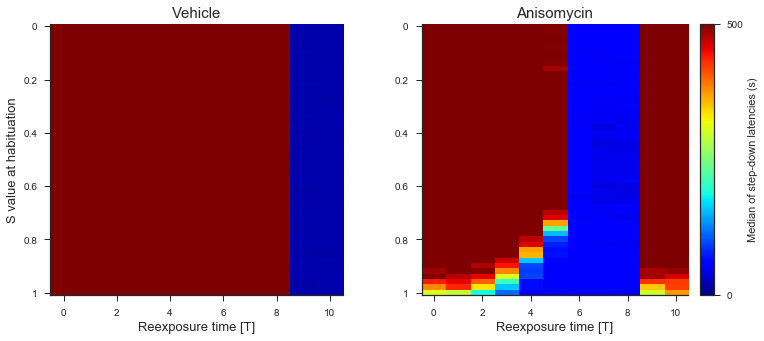

In [25]:
fig = plt.figure(figsize=(12,5))
gs  = gridspec.GridSpec(1,2) # grid for subplots
    
ax0 = plt.subplot(gs[0])
im0 = ax0.imshow(np.split(np.asarray(SDL_MedianV),len(Svalues)),cmap='jet',vmin=0,vmax=500)
ax0.set_xlabel('Reexposure time [T]',size=13)
ax0.set_ylabel('S value at habituation',size=13)
ax0.set_title('Vehicle',size=15)
ax0.set_aspect(0.2)
plt.yticks([0,10,20,30,40,50],[0,0.2,0.4,0.6,0.8,1]);

ax1 = plt.subplot(gs[1])
im1 = ax1.imshow(np.split(np.asarray(SDL_MedianA),len(Svalues)),cmap='jet',vmin=0,vmax=500)
sns.despine()
fig.colorbar(im1,ax=ax1,fraction=0.0458,pad=0.04,label='Median of step-down latencies (s)',ticks=[0,500])
ax1.set_xlabel('Reexposure time [T]',size=13)
ax1.set_title('Anisomycin',size=15)
ax1.set_aspect(0.22)
plt.yticks([0,10,20,30,40,50],[0,0.2,0.4,0.6,0.8,1]);

Non-shock habituation.

In [26]:
SDL_MedianV = [] # list with the medians of the step-down latencies (vehicle)
SDL_MedianA = [] # list with the medians of the step-down latencies (aniso)

for habS in Svalues:
    for T in range(11):
        median,quartil75,quartil25 = SDL_Protocol1(nNeurons,Inr,Ins,Ins,Ic,Ish,T,n,gamma,gammaRA,
                                                   gammaSh,habS,amnesicS,aversiveS,reactS,D,X)
        SDL_MedianV.append(median[0])
        SDL_MedianA.append(median[1])

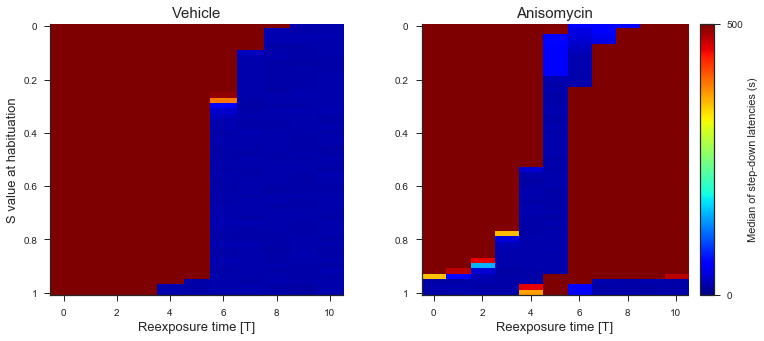

In [27]:
fig = plt.figure(figsize=(12,5))
gs  = gridspec.GridSpec(1,2) # grid for subplots
    
ax0 = plt.subplot(gs[0])
im0 = ax0.imshow(np.split(np.asarray(SDL_MedianV),len(Svalues)),cmap='jet',vmin=0,vmax=500)
ax0.set_xlabel('Reexposure time [T]',size=13)
ax0.set_ylabel('S value at habituation',size=13)
ax0.set_title('Vehicle',size=15)
ax0.set_aspect(0.2)
plt.yticks([0,10,20,30,40,50],[0,0.2,0.4,0.6,0.8,1]);

ax1 = plt.subplot(gs[1])
im1 = ax1.imshow(np.split(np.asarray(SDL_MedianA),len(Svalues)),cmap='jet',vmin=0,vmax=500)
sns.despine()
fig.colorbar(im1,ax=ax1,fraction=0.0458,pad=0.04,label='Median of step-down latencies (s)',ticks=[0,500])
ax1.set_xlabel('Reexposure time [T]',size=13)
ax1.set_title('Anisomycin',size=15)
ax1.set_aspect(0.22)
plt.yticks([0,10,20,30,40,50],[0,0.2,0.4,0.6,0.8,1]);

Control habituation with greater synaptic decay after Training stage.

In [28]:
SDL_MedianV = [] # list with the medians of the step-down latencies (vehicle)
SDL_MedianA = [] # list with the medians of the step-down latencies (aniso)

gammaSh = 0.8 # simulates a longer time after Training (greater synaptic decay)

for habS in Svalues:
    for T in range(11):
        median,quartil75,quartil25 = SDL_Protocol1(nNeurons,Inr,Ict,Ins,Ic,Ish,T,n,gamma,
                                                   gammaRA,gammaSh,habS,amnesicS,aversiveS,reactS,D,X)
        SDL_MedianV.append(median[0])
        SDL_MedianA.append(median[1])

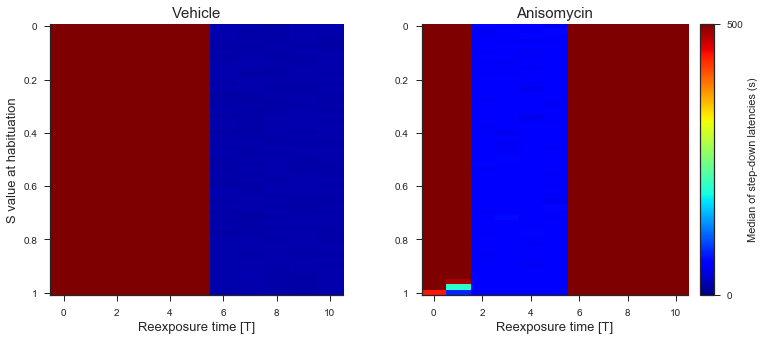

In [29]:
fig = plt.figure(figsize=(12,5))
gs  = gridspec.GridSpec(1,2) # grid for subplots
    
ax0 = plt.subplot(gs[0])
im0 = ax0.imshow(np.split(np.asarray(SDL_MedianV),len(Svalues)),cmap='jet',vmin=0,vmax=500)
ax0.set_xlabel('Reexposure time [T]',size=13)
ax0.set_ylabel('S value at habituation',size=13)
ax0.set_title('Vehicle',size=15)
ax0.set_aspect(0.2)
plt.yticks([0,10,20,30,40,50],[0,0.2,0.4,0.6,0.8,1]);

ax1 = plt.subplot(gs[1])
im1 = ax1.imshow(np.split(np.asarray(SDL_MedianA),len(Svalues)),cmap='jet',vmin=0,vmax=500)
sns.despine()
fig.colorbar(im1,ax=ax1,fraction=0.0458,pad=0.04,label='Median of step-down latencies (s)',ticks=[0,500])
ax1.set_xlabel('Reexposure time [T]',size=13)
ax1.set_title('Anisomycin',size=15)
ax1.set_aspect(0.22)
plt.yticks([0,10,20,30,40,50],[0,0.2,0.4,0.6,0.8,1]);

Non-shock habituation with greater synaptic decay after Training stage.

In [30]:
SDL_MedianV = [] # list with the medians of the step-down latencies (vehicle)
SDL_MedianA = [] # list with the medians of the step-down latencies (aniso)

for habS in Svalues:
    for T in range(11):
        median,quartil75,quartil25 = SDL_Protocol1(nNeurons,Inr,Ins,Ins,Ic,Ish,T,n,gamma,gammaRA,
                                                   gammaSh,habS,amnesicS,aversiveS,reactS,D,X)
        SDL_MedianV.append(median[0])
        SDL_MedianA.append(median[1])

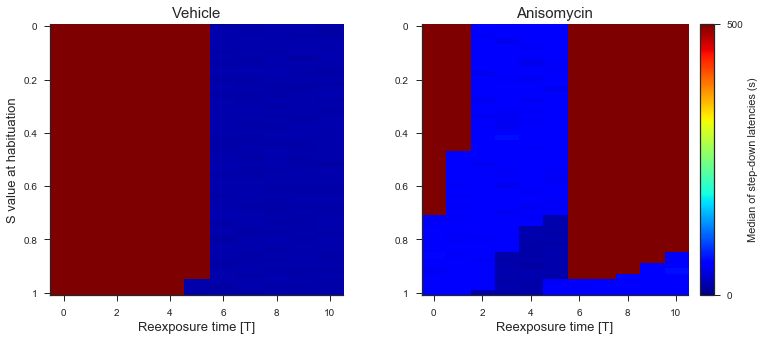

In [31]:
fig = plt.figure(figsize=(12,5))
gs  = gridspec.GridSpec(1,2) # grid for subplots
    
ax0 = plt.subplot(gs[0])
im0 = ax0.imshow(np.split(np.asarray(SDL_MedianV),len(Svalues)),cmap='jet',vmin=0,vmax=500)
ax0.set_xlabel('Reexposure time [T]',size=13)
ax0.set_ylabel('S value at habituation',size=13)
ax0.set_title('Vehicle',size=15)
ax0.set_aspect(0.2)
plt.yticks([0,10,20,30,40,50],[0,0.2,0.4,0.6,0.8,1]);

ax1 = plt.subplot(gs[1])
im1 = ax1.imshow(np.split(np.asarray(SDL_MedianA),len(Svalues)),cmap='jet',vmin=0,vmax=500)
sns.despine()
fig.colorbar(im1,ax=ax1,fraction=0.0458,pad=0.04,label='Median of step-down latencies (s)',ticks=[0,500])
ax1.set_xlabel('Reexposure time [T]',size=13)
ax1.set_title('Anisomycin',size=15)
ax1.set_aspect(0.22)
plt.yticks([0,10,20,30,40,50],[0,0.2,0.4,0.6,0.8,1]);

**Effect of S value at training in relation to the exposure period at reactivation:**

Control habituation.

In [32]:
SDL_MedianV = [] # list with the medians of the step-down latencies (vehicle)
SDL_MedianA = [] # list with the medians of the step-down latencies (aniso)

gammaSh = 0.15 # decay factor applied after training
habS    = 0.8  # synthesis factor at habituation stage

for aversiveS in Svalues:
    for T in range(11):
        median,quartil75,quartil25 = SDL_Protocol1(nNeurons,Inr,Ict,Ins,Ic,Ish,T,n,gamma,gammaRA,
                                                   gammaSh,habS,amnesicS,aversiveS,reactS,D,X)
        SDL_MedianV.append(median[0])
        SDL_MedianA.append(median[1])

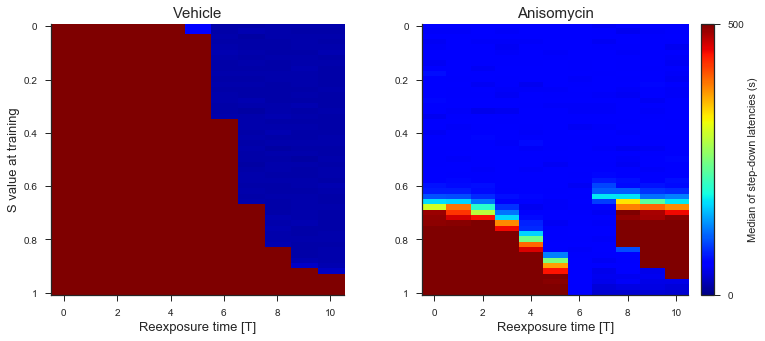

In [33]:
fig = plt.figure(figsize=(12,5))
gs  = gridspec.GridSpec(1,2) # grid for subplots
    
ax0 = plt.subplot(gs[0])
im0 = ax0.imshow(np.split(np.asarray(SDL_MedianV),len(Svalues)),cmap='jet',vmin=0,vmax=500)
ax0.set_xlabel('Reexposure time [T]',size=13)
ax0.set_ylabel('S value at training',size=13)
ax0.set_title('Vehicle',size=15)
ax0.set_aspect(0.2)
plt.yticks([0,10,20,30,40,50],[0,0.2,0.4,0.6,0.8,1]);

ax1 = plt.subplot(gs[1])
im1 = ax1.imshow(np.split(np.asarray(SDL_MedianA),len(Svalues)),cmap='jet',vmin=0,vmax=500)
sns.despine()
fig.colorbar(im1,ax=ax1,fraction=0.0458,pad=0.04,label='Median of step-down latencies (s)',ticks=[0,500])
ax1.set_xlabel('Reexposure time [T]',size=13)
ax1.set_title('Anisomycin',size=15)
ax1.set_aspect(0.22)
plt.yticks([0,10,20,30,40,50],[0,0.2,0.4,0.6,0.8,1]);

Non-shock habituation.

In [34]:
SDL_MedianV = [] # list with the medians of the step-down latencies (vehicle)
SDL_MedianA = [] # list with the medians of the step-down latencies (aniso)

for aversiveS in Svalues:
    for T in range(11):
        median,quartil75,quartil25 = SDL_Protocol1(nNeurons,Inr,Ins,Ins,Ic,Ish,T,n,gamma,gammaRA,
                                                   gammaSh,habS,amnesicS,aversiveS,reactS,D,X)
        SDL_MedianV.append(median[0])
        SDL_MedianA.append(median[1])

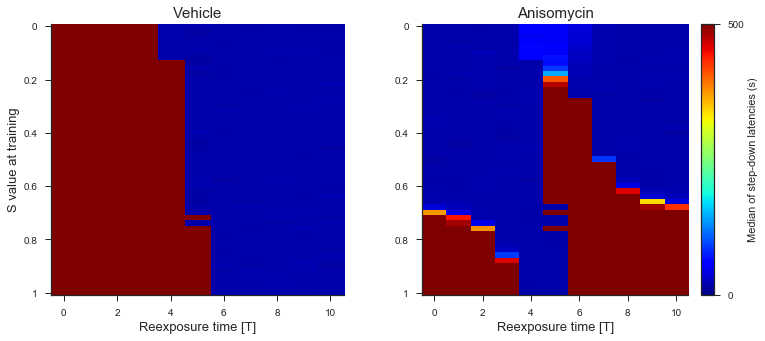

In [35]:
fig = plt.figure(figsize=(12,5))
gs  = gridspec.GridSpec(1,2) # grid for subplots
    
ax0 = plt.subplot(gs[0])
im0 = ax0.imshow(np.split(np.asarray(SDL_MedianV),len(Svalues)),cmap='jet',vmin=0,vmax=500)
ax0.set_xlabel('Reexposure time [T]',size=13)
ax0.set_ylabel('S value at training',size=13)
ax0.set_title('Vehicle',size=15)
ax0.set_aspect(0.2)
plt.yticks([0,10,20,30,40,50],[0,0.2,0.4,0.6,0.8,1]);

ax1 = plt.subplot(gs[1])
im1 = ax1.imshow(np.split(np.asarray(SDL_MedianA),len(Svalues)),cmap='jet',vmin=0,vmax=500)
sns.despine()
fig.colorbar(im1,ax=ax1,fraction=0.0458,pad=0.04,label='Median of step-down latencies (s)',ticks=[0,500])
ax1.set_xlabel('Reexposure time [T]',size=13)
ax1.set_title('Anisomycin',size=15)
ax1.set_aspect(0.22)
plt.yticks([0,10,20,30,40,50],[0,0.2,0.4,0.6,0.8,1]);

**Effect of D value in relation to the exposure period at reactivation:**

Control habituation.

In [36]:
SDL_MedianV = [] # list with the medians of the step-down latencies (vehicle)
SDL_MedianA = [] # list with the medians of the step-down latencies (aniso)

Dvalues = np.arange(0,1.501,0.025)

aversiveS = 0.85 # synthesis factor for aversive memory storage

for D in Dvalues:
    for T in range(11):
        median,quartil75,quartil25 = SDL_Protocol1(nNeurons,Inr,Ict,Ins,Ic,Ish,T,n,gamma,gammaRA,
                                                   gammaSh,habS,amnesicS,aversiveS,reactS,D,X)
        SDL_MedianV.append(median[0])
        SDL_MedianA.append(median[1])

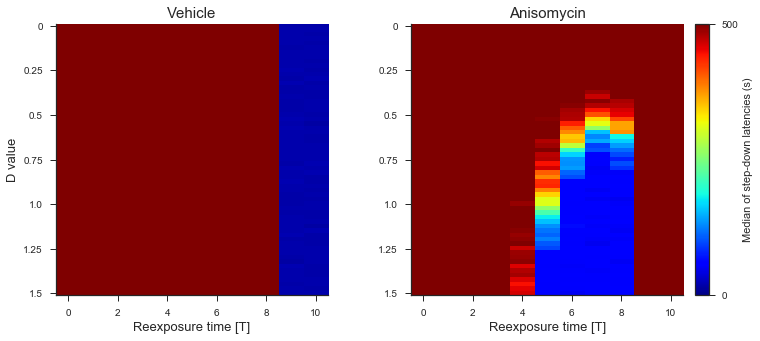

In [37]:
fig = plt.figure(figsize=(12,5))
gs  = gridspec.GridSpec(1,2) # grid for subplots
    
ax0 = plt.subplot(gs[0])
im0 = ax0.imshow(np.split(np.asarray(SDL_MedianV),len(Dvalues)),cmap='jet',vmin=0,vmax=500)
ax0.set_xlabel('Reexposure time [T]',size=13)
ax0.set_ylabel('D value',size=13)
ax0.set_title('Vehicle',size=15)
ax0.set_aspect(0.18)
plt.yticks([0,10,20,30,40,50,60],[0,0.25,0.5,0.75,1.,1.25,1.5]);

ax1 = plt.subplot(gs[1])
im1 = ax1.imshow(np.split(np.asarray(SDL_MedianA),len(Dvalues)),cmap='jet',vmin=0,vmax=500)
sns.despine()
fig.colorbar(im1,ax=ax1,fraction=0.0458,pad=0.04,label='Median of step-down latencies (s)',ticks=[0,500])
ax1.set_xlabel('Reexposure time [T]',size=13)
ax1.set_title('Anisomycin',size=15)
ax1.set_aspect(0.18)
plt.yticks([0,10,20,30,40,50,60],[0,0.25,0.5,0.75,1.,1.25,1.5]);

Non-shock habituation.

In [38]:
SDL_MedianV = [] # list with the medians of the step-down latencies (vehicle)
SDL_MedianA = [] # list with the medians of the step-down latencies (aniso)

for D in Dvalues:
    for T in range(11):
        median,quartil75,quartil25 = SDL_Protocol1(nNeurons,Inr,Ins,Ins,Ic,Ish,T,n,gamma,gammaRA,
                                                   gammaSh,habS,amnesicS,aversiveS,reactS,D,X)
        SDL_MedianV.append(median[0])
        SDL_MedianA.append(median[1])

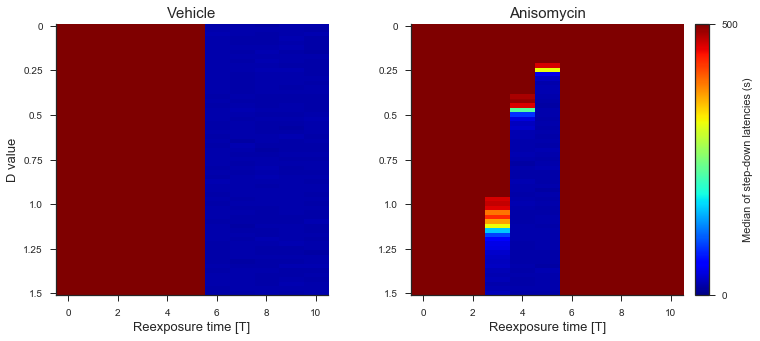

In [39]:
fig = plt.figure(figsize=(12,5))
gs  = gridspec.GridSpec(1,2) # grid for subplots
    
ax0 = plt.subplot(gs[0])
im0 = ax0.imshow(np.split(np.asarray(SDL_MedianV),len(Dvalues)),cmap='jet',vmin=0,vmax=500)
ax0.set_xlabel('Reexposure time [T]',size=13)
ax0.set_ylabel('D value',size=13)
ax0.set_title('Vehicle',size=15)
ax0.set_aspect(0.18)
plt.yticks([0,10,20,30,40,50,60],[0,0.25,0.5,0.75,1.,1.25,1.5]);

ax1 = plt.subplot(gs[1])
im1 = ax1.imshow(np.split(np.asarray(SDL_MedianA),len(Dvalues)),cmap='jet',vmin=0,vmax=500)
sns.despine()
fig.colorbar(im1,ax=ax1,fraction=0.0458,pad=0.04,label='Median of step-down latencies (s)',ticks=[0,500])
ax1.set_xlabel('Reexposure time [T]',size=13)
ax1.set_title('Anisomycin',size=15)
ax1.set_aspect(0.18)
plt.yticks([0,10,20,30,40,50,60],[0,0.25,0.5,0.75,1.,1.25,1.5]);

**Effect of gamma value post training in relation to the exposure period at reactivation:**

Control habituation.

In [40]:
SDL_MedianV = [] # list with the medians of the step-down latencies (vehicle)
SDL_MedianA = [] # list with the medians of the step-down latencies (aniso)

Gvalues = np.arange(0,1.001,0.02)

D = 1.25 # degradation factor

for gammaSh in Gvalues:
    for T in range(11):
        median,quartil75,quartil25 = SDL_Protocol1(nNeurons,Inr,Ict,Ins,Ic,Ish,T,n,gamma,gammaRA,
                                                   gammaSh,habS,amnesicS,aversiveS,reactS,D,X)
        SDL_MedianV.append(median[0])
        SDL_MedianA.append(median[1])

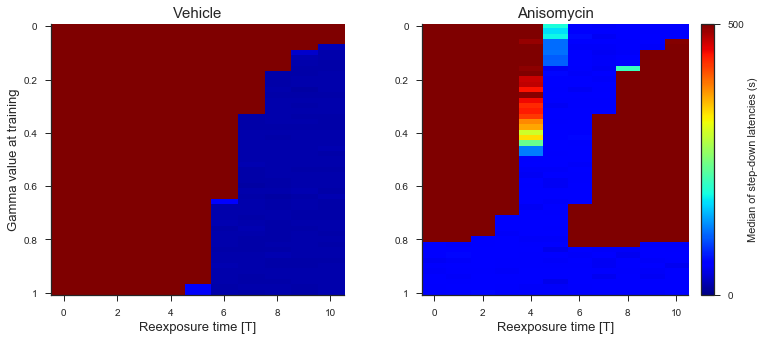

In [41]:
fig = plt.figure(figsize=(12,5))
gs  = gridspec.GridSpec(1,2) # grid for subplots
    
ax0 = plt.subplot(gs[0])
im0 = ax0.imshow(np.split(np.asarray(SDL_MedianV),len(Svalues)),cmap='jet',vmin=0,vmax=500)
ax0.set_xlabel('Reexposure time [T]',size=13)
ax0.set_ylabel('Gamma value at training',size=13)
ax0.set_title('Vehicle',size=15)
ax0.set_aspect(0.2)
plt.yticks([0,10,20,30,40,50],[0,0.2,0.4,0.6,0.8,1]);

ax1 = plt.subplot(gs[1])
im1 = ax1.imshow(np.split(np.asarray(SDL_MedianA),len(Svalues)),cmap='jet',vmin=0,vmax=500)
sns.despine()
fig.colorbar(im1,ax=ax1,fraction=0.0458,pad=0.04,label='Median of step-down latencies (s)',ticks=[0,500])
ax1.set_xlabel('Reexposure time [T]',size=13)
ax1.set_title('Anisomycin',size=15)
ax1.set_aspect(0.22)
plt.yticks([0,10,20,30,40,50],[0,0.2,0.4,0.6,0.8,1]);

Non-shock habituation.

In [42]:
SDL_MedianV = [] # list with the medians of the step-down latencies (vehicle)
SDL_MedianA = [] # list with the medians of the step-down latencies (aniso)

Gvalues = np.arange(0,1.001,0.02)

for gammaSh in Gvalues:
    for T in range(11):
        median,quartil75,quartil25 = SDL_Protocol1(nNeurons,Inr,Ins,Ins,Ic,Ish,T,n,gamma,gammaRA,
                                                   gammaSh,habS,amnesicS,aversiveS,reactS,D,X)
        SDL_MedianV.append(median[0])
        SDL_MedianA.append(median[1])

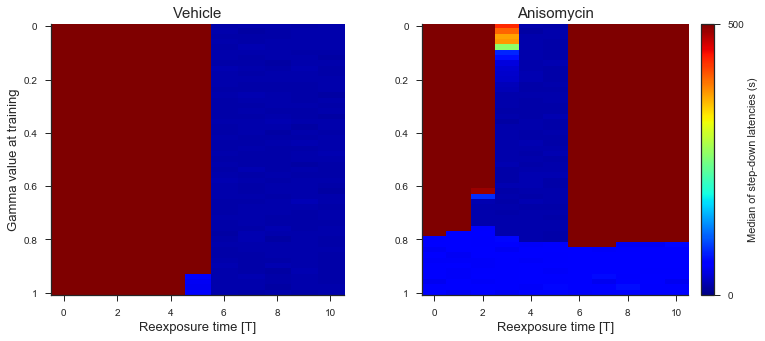

In [43]:
fig = plt.figure(figsize=(12,5))
gs  = gridspec.GridSpec(1,2) # grid for subplots
    
ax0 = plt.subplot(gs[0])
im0 = ax0.imshow(np.split(np.asarray(SDL_MedianV),len(Svalues)),cmap='jet',vmin=0,vmax=500)
ax0.set_xlabel('Reexposure time [T]',size=13)
ax0.set_ylabel('Gamma value at training',size=13)
ax0.set_title('Vehicle',size=15)
ax0.set_aspect(0.2)
plt.yticks([0,10,20,30,40,50],[0,0.2,0.4,0.6,0.8,1]);

ax1 = plt.subplot(gs[1])
im1 = ax1.imshow(np.split(np.asarray(SDL_MedianA),len(Svalues)),cmap='jet',vmin=0,vmax=500)
sns.despine()
fig.colorbar(im1,ax=ax1,fraction=0.0458,pad=0.04,label='Median of step-down latencies (s)',ticks=[0,500])
ax1.set_xlabel('Reexposure time [T]',size=13)
ax1.set_title('Anisomycin',size=15)
ax1.set_aspect(0.22)
plt.yticks([0,10,20,30,40,50],[0,0.2,0.4,0.6,0.8,1]);

#### Energy values of the shock and non-shock attractors in function of reexposure patterns:

In [44]:
gamma     = 0.15 # decay factor applied after habituation and training
habS      = 0.8  # synthesis factor at habituation stage
reactS    = 0.85 # synthesis factor at reactivation stage
amnesicS  = 0.   # synthesis factor that simulates the amnesic drug
aversiveS = 0.85 # synthesis factor for aversive memory storage
D         = 1.25 # degradation factor
nPoints   = 200  # number of points of each trace

E = np.zeros((8,nPoints)) # energies matrix
allPatterns = (X+1)/2     # all patterns (states = [0, 1])
scenario = -1             # indicates habituation scenarios

for Ihab in [Ict,Ins]: # for each habituation input patern
    for pattern in range(4): # for each attractor
        scenario += 1 # indicates the habituation group (control/non-shock)
        count = 0 # indicates the reexposure group (vehicle/aniso)
        
        # Matrix of weights initialization
        W0 = np.zeros((nNeurons,nNeurons))

        # Non-related memory storage
        u0 = np.random.rand(nNeurons)*0.1 # initial network state
        Wnr,u,t,uDynamics = trainNetwork(W0,u0,Inr,habS,D) #storage
        Wnr = (1.-gamma)*Wnr # time-dependent synptic decay

        # Habituation
        u0 = np.random.rand(nNeurons)*0.1 # initial network state
        Wha,u,t,uDynamics = trainNetwork(Wnr,u0,Ihab,habS,D) # storage
        Wha = (1.-gamma)*Wha # time-dependent synptic decay

        # Shock memory storage (Training)
        u0 = np.random.rand(nNeurons)*0.1 # initial network state
        Wsh,u,t,uDynamics = trainNetwork(Wha,u0,Ish,aversiveS,D) # storage
        Wsh = (1.-gamma)*Wsh # time-dependent synptic decay
     
        for T in np.linspace(0,10,nPoints): # for each reexposition pattern
            ## VEHICLE ##
            # SD-IA Reactivation
            I = Ish+(Ins-Ish)/(1+np.exp(10./2.-T))
            u0 = np.random.rand(nNeurons)*0.1 # initial network state
            Wra,u,t,uDynamics = trainNetwork(Wsh,u0,I,reactS,D) # storage
            Wra = (1.-gamma)*Wra # time-dependent synaptic decay
            
            # Energy calculation
            Sum = 0 # sum from the energy equation
            for i in range(nNeurons):
                for j in range(nNeurons):
                    Sum += Wra[i,j]*allPatterns[pattern,j]*(2*allPatterns[pattern,i]-1.)
            E[scenario,count] += -Sum # energy value
            count += 1 # changes position of E to "1" for storing "aniso" group energy

E = (E - np.min(E))/(np.max(E)-np.min(E)) # normalization

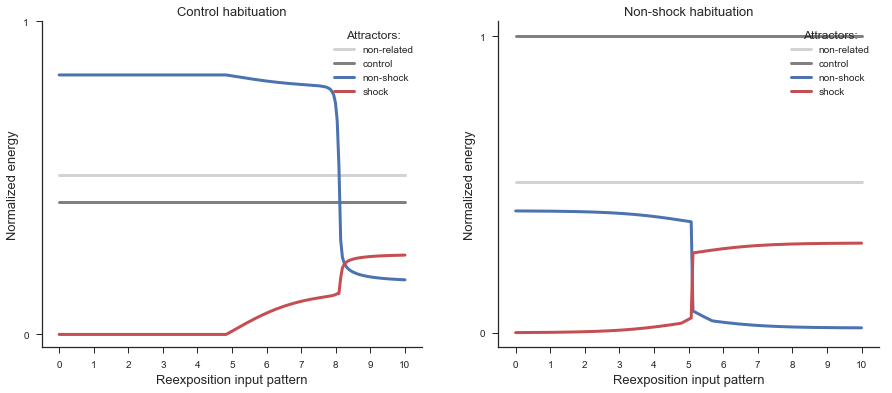

In [45]:
plt.figure(figsize=((15,6)))

# Control habituation group
plt.subplot(121)
plt.plot(np.linspace(0,10,nPoints),E[0],label='non-related',linewidth=3,color='lightgrey')
plt.plot(np.linspace(0,10,nPoints),E[1],label='control',linewidth=3,color='grey')
plt.plot(np.linspace(0,10,nPoints),E[2],label='non-shock',linewidth=3,color='C0')
plt.plot(np.linspace(0,10,nPoints),E[3],label='shock',linewidth=3,color='C2')
plt.legend(title='Attractors:')
plt.xticks(range(11))
plt.yticks([0,1])
plt.ylabel('Normalized energy',size=13)
plt.xlabel('Reexposition input pattern',size=13)
plt.title('Control habituation',size=13)
sns.despine()

# Non-shock habituation group
plt.subplot(122)
plt.plot(np.linspace(0,10,nPoints),E[4],label='non-related',linewidth=3,color='lightgrey')
plt.plot(np.linspace(0,10,nPoints),E[5],label='control',linewidth=3,color='grey')
plt.plot(np.linspace(0,10,nPoints),E[6],label='non-shock',linewidth=3,color='C0')
plt.plot(np.linspace(0,10,nPoints),E[7],label='shock',linewidth=3,color='C2')
plt.legend(title='Attractors:')
plt.xticks(range(11))
plt.yticks([0,1])
plt.ylabel('Normalized energy',size=13)
plt.xlabel('Reexposition input pattern',size=13)
plt.title('Non-shock habituation',size=13)
sns.despine()

In [46]:
E = np.zeros((8,nPoints)) # energies matrix
allPatterns = (X+1)/2     # all patterns (states = [0, 1])
scenario = -1             # indicates habituation scenarios

for Ihab in [Ict,Ins]: # for each habituation input patern
    for pattern in range(4): # for each attractor
        scenario += 1 # indicates the habituation group (control/non-shock)
        count = 0 # indicates the reexposure group (vehicle/aniso)
        
        # Matrix of weights initialization
        W0 = np.zeros((nNeurons,nNeurons))

        # Non-related memory storage
        u0 = np.random.rand(nNeurons)*0.1 # initial network state
        Wnr,u,t,uDynamics = trainNetwork(W0,u0,Inr,habS,D) #storage
        Wnr = (1.-gamma)*Wnr # time-dependent synptic decay

        # Habituation
        u0 = np.random.rand(nNeurons)*0.1 # initial network state
        Wha,u,t,uDynamics = trainNetwork(Wnr,u0,Ihab,habS,D) # storage
        Wha = (1.-gamma)*Wha # time-dependent synptic decay

        # Shock memory storage (Training)
        u0 = np.random.rand(nNeurons)*0.1 # initial network state
        Wsh,u,t,uDynamics = trainNetwork(Wha,u0,Ish,aversiveS,D) # storage
        Wsh = (1.-gamma)*Wsh # time-dependent synptic decay
     
        for T in np.linspace(0,10,nPoints): # for each reexposition pattern
            ## VEHICLE ##
            # SD-IA Reactivation
            I = Ish+(Ins-Ish)/(1+np.exp(10./2.-T))
            u0 = np.random.rand(nNeurons)*0.1 # initial network state
            Wra,u,t,uDynamics = trainNetwork(Wsh,u0,I,amnesicS,D) # storage
            Wra = (1.-gamma)*Wra # time-dependent synaptic decay
            
            # Energy calculation
            Sum = 0 # sum from the energy equation
            for i in range(nNeurons):
                for j in range(nNeurons):
                    Sum += Wra[i,j]*allPatterns[pattern,j]*(2*allPatterns[pattern,i]-1.)
            E[scenario,count] += -Sum # energy value
            count += 1 # changes position of E to "1" for storing "aniso" group energy

E = (E - np.min(E))/(np.max(E)-np.min(E)) # normalization

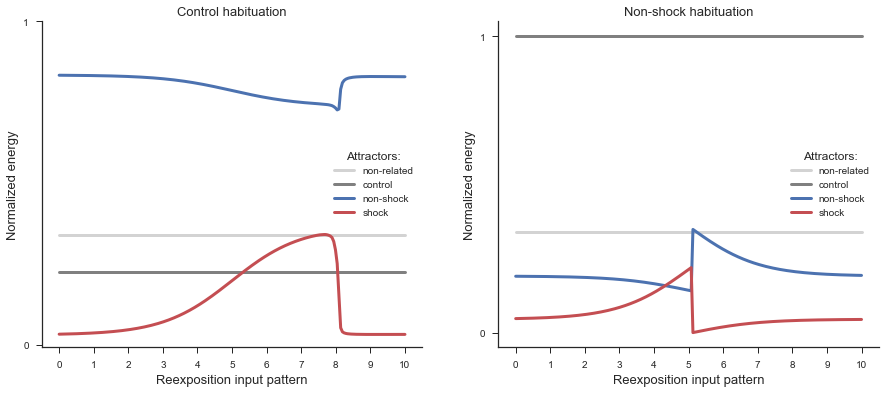

In [47]:
plt.figure(figsize=((15,6)))

# Control habituation group
plt.subplot(121)
plt.plot(np.linspace(0,10,nPoints),E[0],label='non-related',linewidth=3,color='lightgrey')
plt.plot(np.linspace(0,10,nPoints),E[1],label='control',linewidth=3,color='grey')
plt.plot(np.linspace(0,10,nPoints),E[2],label='non-shock',linewidth=3,color='C0')
plt.plot(np.linspace(0,10,nPoints),E[3],label='shock',linewidth=3,color='C2')
plt.legend(title='Attractors:')
plt.xticks(range(11))
plt.yticks([0,1])
plt.ylabel('Normalized energy',size=13)
plt.xlabel('Reexposition input pattern',size=13)
plt.title('Control habituation',size=13)
sns.despine()

# Non-shock habituation group
plt.subplot(122)
plt.plot(np.linspace(0,10,nPoints),E[4],label='non-related',linewidth=3,color='lightgrey')
plt.plot(np.linspace(0,10,nPoints),E[5],label='control',linewidth=3,color='grey')
plt.plot(np.linspace(0,10,nPoints),E[6],label='non-shock',linewidth=3,color='C0')
plt.plot(np.linspace(0,10,nPoints),E[7],label='shock',linewidth=3,color='C2')
plt.legend(title='Attractors:')
plt.xticks(range(11))
plt.yticks([0,1])
plt.ylabel('Normalized energy',size=13)
plt.xlabel('Reexposition input pattern',size=13)
plt.title('Non-shock habituation',size=13)
sns.despine()